In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pathlib import Path
import os

image_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/BEHSOF_images.csv')
image_paths = image_data['Patient ID'].values
image_labels = image_data['Steatosis stage']

simplified_paths = [str(Path(path)) for path in image_paths]
clean_paths = [path.replace('\\', '/') for path in simplified_paths]

print(image_labels)

0      3
1      1
2      1
3      1
4      2
      ..
108    1
109    2
110    1
111    1
112    1
Name: Steatosis stage, Length: 113, dtype: int64


In [ ]:
paths = []
labels = []
augment_per_image = 2

for z, i in enumerate(clean_paths):
    full_dir_path = "/content/drive/MyDrive/Colab_Notebooks" + i
    images = os.listdir(full_dir_path)
    if(len(images) == 0):
      print(full_dir_path)
    for j in images:
        full_image_path = os.path.join(full_dir_path, j)
        paths.append(full_image_path)
        labels.append(image_labels[z])

data = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print(data.head())


                                          image_path  label
0  /content/drive/MyDrive/Colab_Notebooks/Data/TA...      3
1  /content/drive/MyDrive/Colab_Notebooks/Data/TA...      1
2  /content/drive/MyDrive/Colab_Notebooks/Data/TA...      1
3  /content/drive/MyDrive/Colab_Notebooks/Data/TA...      1
4  /content/drive/MyDrive/Colab_Notebooks/Data/TA...      1


In [ ]:
a,b,c,d = 0,0,0,0

for i in data.label:
  if( i == 0 ):
    a = a +  1
  elif( i == 1 ):
    b = b + 1
  elif( i == 2 ):
    c = c + 1
  else:
    d = d + 1
print(a,b,c,d)

153 842 552 117


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import albumentations as A
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import Counter

TARGET_PER_CLASS = 2000
NUM_WORKERS = 4  # Adjust based on CPU cores
IMAGE_SIZE = (256, 256)

strong_aug = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.Rotate(limit=35, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=5, p=0.2),
    A.CoarseDropout(max_holes=8, p=0.3)
])

light_aug = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.HorizontalFlip(p=0.3)
])

def analyze_balance(df):
    """Calculate how many augmented images each class needs"""
    counts = Counter(df['label'])
    augmentation_needs = {}

    for label, count in counts.items():
        needed = max(0, TARGET_PER_CLASS - count)
        if needed > 0:
            # Calculate how many copies per original image
            copies_per_image = int(np.ceil(needed / count))
            augmentation_needs[label] = copies_per_image

    return augmentation_needs

def augment_image(img_path, label, output_dir, augment_times):
    """Apply augmentation and save images"""
    try:
        img = cv2.imread(img_path)
        if img is None:
            return []

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = []

        # Always save light-augmented original
        light_augmented = light_aug(image=img)['image']
        orig_path = os.path.join(output_dir, f"orig_{os.path.basename(img_path)}")
        cv2.imwrite(orig_path, cv2.cvtColor(light_augmented, cv2.COLOR_RGB2BGR))
        results.append((orig_path, label))

        # Add strong augmentations if needed
        for i in range(augment_times):
            augmented = strong_aug(image=img)['image']
            aug_path = os.path.join(output_dir, f"aug{i}_{os.path.basename(img_path)}")
            cv2.imwrite(aug_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            results.append((aug_path, label))

        return results
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return []

def balance_dataset(df, output_root):
    """Create balanced dataset with 900 images per class"""
    augmentation_needs = analyze_balance(df)
    all_results = []

    # Group by label for efficient processing
    grouped = df.groupby('label')

    for label, group in tqdm(grouped, desc="Balancing classes"):
        output_dir = os.path.join(output_root, str(label))
        os.makedirs(output_dir, exist_ok=True)

        augment_times = augmentation_needs.get(label, 0)
        img_paths = group['image_path'].tolist()

        # Parallel processing
        results = Parallel(n_jobs=NUM_WORKERS)(
            delayed(augment_image)(path, label, output_dir, augment_times)
            for path in img_paths
        )

        for batch in results:
            all_results.extend(batch)

    return pd.DataFrame(all_results, columns=["image_path", "label"])

balanced_data = balance_dataset(data, "/content/balanced_dataset")

# Verify results
print("\nFinal class distribution:")
print(balanced_data['label'].value_counts())

# Save the dataframe
balanced_data.to_csv("balanced_dataset.csv", index=False)
print(f"\nSaved {len(balanced_data)} images total")

<ipython-input-10-11ac02dcb07d>:21: UserWarning: Argument(s) 'max_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, p=0.3)
Balancing classes: 100%|██████████| 4/4 [00:46<00:00, 11.71s/it]


Final class distribution:
label
1    2421
2    2160
3    2052
0    1848
Name: count, dtype: int64

Saved 8481 images total


In [ ]:
print(balanced_data.head())

                                   image_path  label
0  /content/balanced_dataset/0/orig_Image.jpg      0
1  /content/balanced_dataset/0/aug0_Image.jpg      0
2  /content/balanced_dataset/0/aug1_Image.jpg      0
3  /content/balanced_dataset/0/aug2_Image.jpg      0
4  /content/balanced_dataset/0/aug3_Image.jpg      0


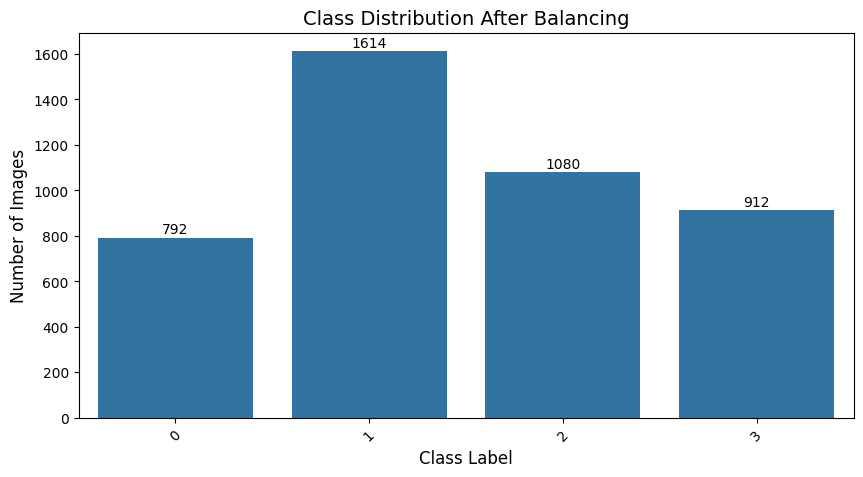

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count samples per class
class_counts = balanced_data['label'].value_counts().sort_index()

# Bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution After Balancing", fontsize=14)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)

# Add value labels
for i, count in enumerate(class_counts):
    plt.text(i, count+5, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
from skimage.feature import local_binary_pattern
from scipy import stats
def rotation_invariant_lbp(image):
    P=8
    R=2
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=P, R=R, method='default')
    bins = P + 2
    hist, _ = np.histogram(lbp, bins=bins, range=(0, bins))

    # Add texture metrics
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-6)

    return lbp

    # return {
    #     'lbp_hist': hist,
    #     'lbp_mean': np.mean(lbp),
    #     'lbp_std': np.std(lbp),
    #     'lbp_entropy': stats.entropy(hist)
    # }

In [ ]:
# features = []

# for index,row in balanced_data.iterrows():
#   features.append(rotation_invariant_lbp(cv2.imread(row['image_path'])))

In [ ]:
def get_normalized_lbp_features(image, depth_factor=1.0):

    features = rotation_invariant_lbp(image)

    print(features);

    MEAN_MEAN = 0.0
    STD_MEAN = 0.0
    STD_STD = 1.0
    ENTROPY_MEAN = 0.0
    ENTROPY_STD = 1.0

    normalized_features = {
        'lbp_hist': features['lbp_hist'],
        'lbp_mean': (features['lbp_mean'] - MEAN_MEAN) / STD_MEAN * depth_factor,
        'lbp_std': (features['lbp_std'] - STD_MEAN) / STD_STD,
        'lbp_entropy': (features['lbp_entropy'] - ENTROPY_MEAN) / ENTROPY_STD
    }

    return normalized_features

In [ ]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
def extract_normalized_features(balanced_data):
    """Extract and normalize features from balanced dataset"""
    # First pass: extract all raw features
    features = []
    valid_indices = []  # Track successfully processed images
    image_paths = []

    print("Extracting raw features...")
    for idx, row in tqdm(balanced_data.iterrows(), total=len(balanced_data)):
        try:
            img = cv2.imread(row['image_path'])
            if img is None:
                print(f"Warning: Could not read image {row['image_path']}")
                continue

            features.append(rotation_invariant_lbp(img))
            valid_indices.append(idx)
            image_paths.append(row['image_path'])
        except Exception as e:
            print(f"Error processing {row['image_path']}: {str(e)}")

    # Convert to numpy arrays for scaling
    lbp_means = np.array([f['lbp_mean'] for f in features]).reshape(-1, 1)
    lbp_stds = np.array([f['lbp_std'] for f in features]).reshape(-1, 1)
    lbp_entropies = np.array([f['lbp_entropy'] for f in features]).reshape(-1, 1)

    # Initialize and fit scalers
    print("Normalizing features...")
    mean_scaler = StandardScaler()
    std_scaler = StandardScaler()
    entropy_scaler = StandardScaler()

    normalized_means = mean_scaler.fit_transform(lbp_means)
    normalized_stds = std_scaler.fit_transform(lbp_stds)
    normalized_entropies = entropy_scaler.fit_transform(lbp_entropies)

    # Create final normalized feature dictionary
    normalized_features = []
    for i, feat in enumerate(features):
        normalized_features.append({
            'image_path': image_paths[i],
            'label': balanced_data.loc[valid_indices[i], 'label'],
            'lbp_hist': feat['lbp_hist'],  # Already normalized
            'lbp_mean': normalized_means[i][0],
            'lbp_std': normalized_stds[i][0],
            'lbp_entropy': normalized_entropies[i][0]
        })

    return normalized_features

# Usage:
normalized_features = extract_normalized_features(balanced_data)

Extracting raw features...


100%|██████████| 4398/4398 [01:24<00:00, 51.76it/s]

Normalizing features...


In [ ]:
print(normalized_features[0])

[{'image_path': '/content/balanced_dataset/0/orig_Image.jpg', 'label': np.int64(0), 'lbp_hist': array([0.27582774, 0.30831465, 0.        , 0.15372169, 0.        ,
       0.03609659, 0.        , 0.14500871, 0.        , 0.03547423,
       0.        , 0.02427184, 0.        , 0.02128454], dtype=float32), 'lbp_mean': np.float64(0.012264659579629128), 'lbp_std': np.float64(1.0200783974901022), 'lbp_entropy': np.float64(0.7137316046641995)}, {'image_path': '/content/balanced_dataset/0/aug0_Image.jpg', 'label': np.int64(0), 'lbp_hist': array([0.28707257, 0.29157633, 0.        , 0.1736447 , 0.        ,
       0.0323603 , 0.        , 0.1499583 , 0.        , 0.03269391,
       0.        , 0.01534612, 0.        , 0.01734779], dtype=float32), 'lbp_mean': np.float64(0.9771540153847288), 'lbp_std': np.float64(-0.0024419655491958636), 'lbp_entropy': np.float64(0.299509855381995)}, {'image_path': '/content/balanced_dataset/0/aug1_Image.jpg', 'label': np.int64(0), 'lbp_hist': array([0.13100436, 0.126013

In [ ]:
def features_to_matrix(normalized_features):
    """Convert normalized features to 2D numpy array"""
    X = []
    for feat in normalized_features:
        # Combine histogram and statistical features
        feature_vec = np.concatenate([
            feat['lbp_hist'],
            [feat['lbp_mean'], feat['lbp_std'], feat['lbp_entropy']]
        ])
        X.append(feature_vec)
    return np.array(X)


X = features_to_matrix(normalized_features)
y = np.array([feat['label'] for feat in normalized_features])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = np.array([np.concatenate([
    feat['lbp_hist'],           # This is an array
    [feat['lbp_mean'],          # Wrap single values in a list
     feat['lbp_std'],
     feat['lbp_entropy']]
]) for feat in normalized_features])

# Encode labels
y = np.array([feat['label'] for feat in normalized_features])
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Split data (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Class distribution: {np.bincount(y_train)} (train), {np.bincount(y_test)} (test)")

Training samples: 3518, Test samples: 880
Class distribution: [ 634 1291  864  729] (train), [158 323 216 183] (test)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Random Forest Performance:
Accuracy: 0.99


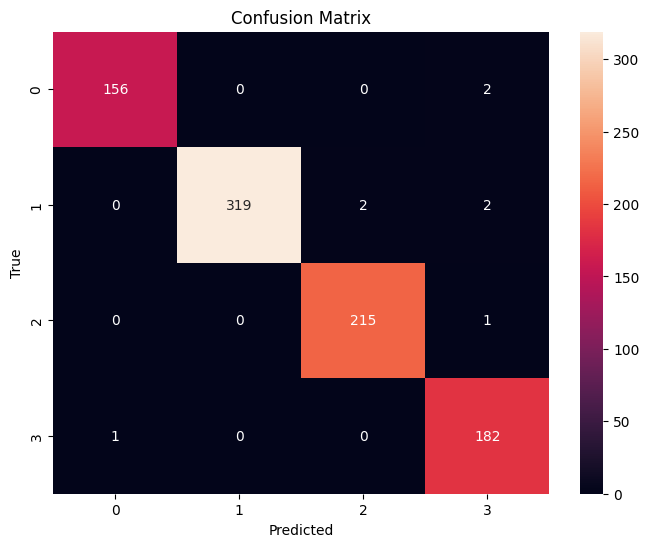

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Performance:")

# print(classification_report(y_test, y_pred, target_names=le.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


SVM Performance:
Accuracy: 0.80


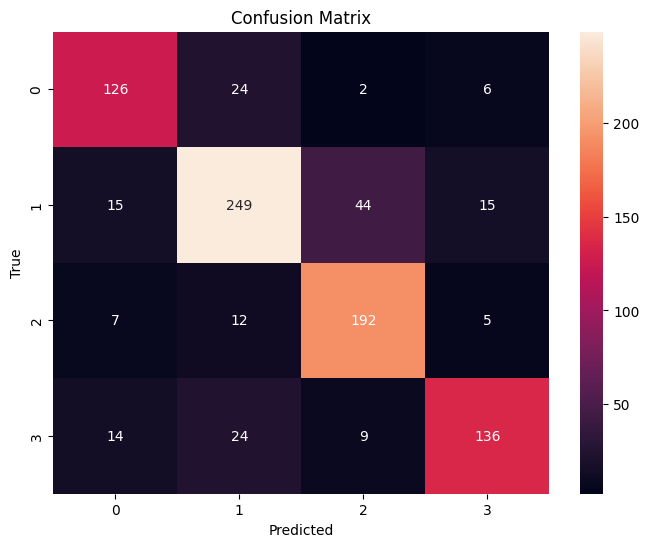

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

svm = make_pipeline(
    StandardScaler(),  # Important for SVM
    SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True
    )
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("\nSVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Build ANN model
def build_ann(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize model
input_shape = X_train.shape[1]
num_classes = len(np.unique(y))
model = build_ann(input_shape, num_classes)
model.summary()

# 3. Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,668 (53.39 KB)

 Trainable params: 13,220 (51.64 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4140 - loss: 1.4385 - val_accuracy: 0.6125 - val_loss: 1.0523
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6433 - loss: 0.8850 - val_accuracy: 0.6795 - val_loss: 0.8643
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7197 - loss: 0.7348 - val_accuracy: 0.7693 - val_loss: 0.6693
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 0.6613 - val_accuracy: 0.7932 - val_loss: 0.5380
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7662 - loss: 0.5905 - val_accuracy: 0.8148 - val_loss: 0.4378
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7720 - loss: 0.5604 - val_accuracy: 0.8545 - val_loss: 0.3580
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8150 - loss: 0.4940 - val_accuracy: 0.8625 - val_loss: 0.3317
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8060 - loss: 0.4832 - val_ac


Test Accuracy: 0.9909
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


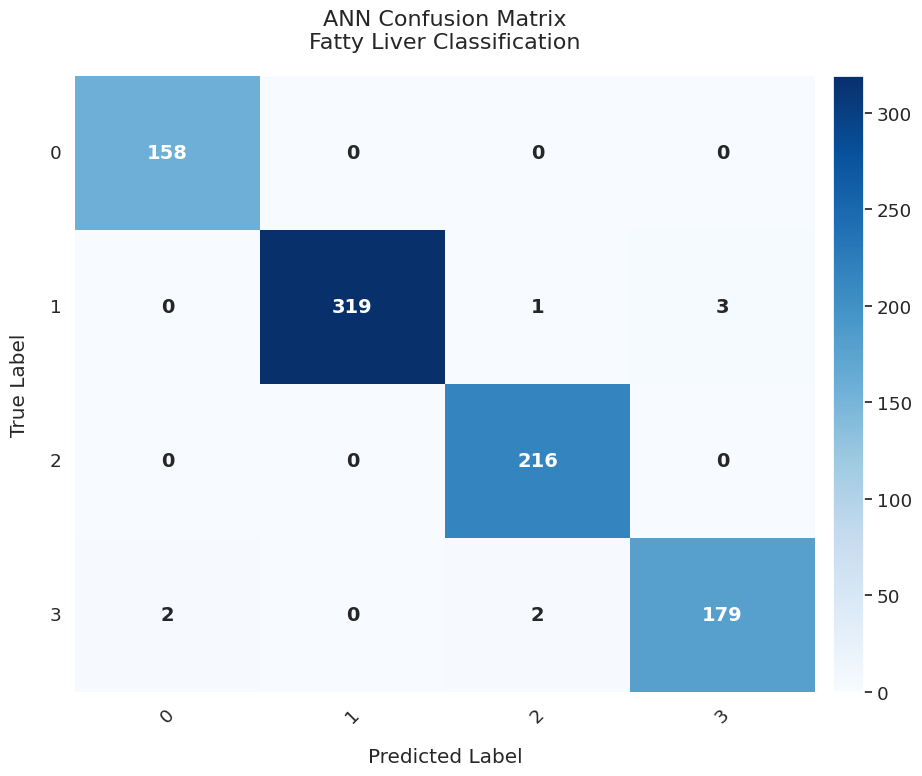

In [ ]:
# 4. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# 1. Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plot with enhanced visualization
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size

# Create heatmap with annotations
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    annot_kws={'size': 14, 'weight': 'bold'},
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
# Customize plot
plt.title('ANN Confusion Matrix\nFatty Liver Classification', pad=20, fontsize=16)
plt.xlabel('Predicted Label', labelpad=15)
plt.ylabel('True Label', labelpad=15)
plt.xticks(rotation=45 if len(le.classes_) > 3 else 0)
plt.yticks(rotation=0)

# Add colorbar for reference
plt.colorbar(ax.collections[0], pad=0.02)
plt.tight_layout()
plt.show()